## Predictive modeling - Random forest regressor model (Daily mean tempreture)

In [43]:
import pandas as pd
import numpy as np  
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, r2_score


In [44]:
kandy_weather = pd.read_csv('../data/processed/kandy_weather_cleaned.csv', index_col=0, parse_dates=['time'])

In [45]:
#drop highly correlated columns 
kandy_weather = kandy_weather.drop(columns=['apparent_temperature_mean'])

In [46]:

# --- Define features and target ---
numerical_vars = ['shortwave_radiation', 'rainfall', 'max_wind_speed', 
                  'max_wind_gust', 'dominant_Wind_Direction', 'evapotranspiration', 'rain_tomorrow', 'year', ]  
categorical_vars = ['weathercode'] 
target = 'mean_temperature'

# --- One-hot encode categorical variables using get_dummies ---
columns_to_use = categorical_vars + numerical_vars + [target]
kandy_weather_dummies = pd.get_dummies(kandy_weather[columns_to_use],
                                       columns=categorical_vars,
                                       drop_first=True)

# Features (after encoding categorical variables)
X = kandy_weather_dummies.drop(columns=target)
y = kandy_weather_dummies[target]

# Example: chronological split
train_set = kandy_weather_dummies[kandy_weather_dummies['year'] <= 2018]
validation_set = kandy_weather_dummies[kandy_weather_dummies['year'] == 2019]
test_set = kandy_weather_dummies[kandy_weather_dummies['year'] >= 2020]

x_train = train_set.drop(columns=target)
y_train = train_set[target]

x_val = validation_set.drop(columns=target)
y_val = validation_set[target]

x_test = test_set.drop(columns=target)
y_test = test_set[target]


In [47]:
# Initialize the model
rf_model = RandomForestRegressor(
    n_estimators=200,      # number of trees
    max_depth=None,        # let trees expand fully
    random_state=42,       # reproducibility
    n_jobs=-1              # use all CPU cores
)

# Train
rf_model.fit(x_train, y_train)


,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [48]:
# Predictions
y_val_pred = rf_model.predict(x_val)

# Metrics
mse = mean_squared_error(y_val, y_val_pred)
rmse = mse ** 0.5
r2 = r2_score(y_val, y_val_pred)

print("Validation RMSE:", rmse)
print("Validation R²:", r2)

Validation RMSE: 0.6457040661912343
Validation R²: 0.7307322358818849


In [49]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_test_pred = rf_model.predict(x_test)

mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)

print("Test RMSE:", rmse)
print("Test R²:", r2_score(y_test, y_test_pred))


Test RMSE: 0.6262900706311753
Test R²: 0.689453597308072


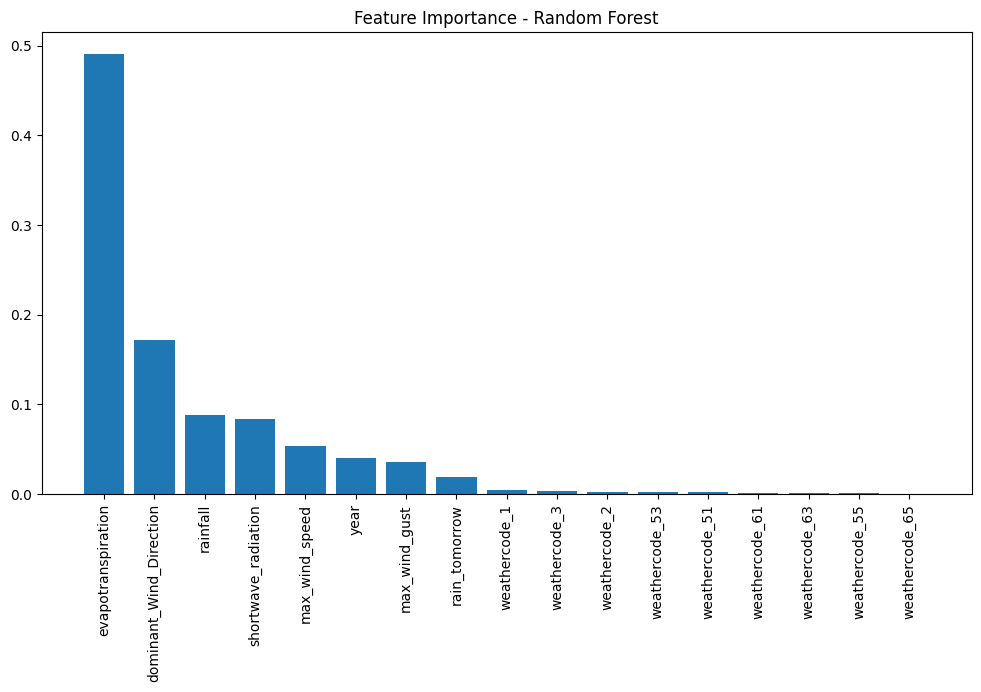

In [50]:
import matplotlib.pyplot as plt
import numpy as np

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.bar(range(x_train.shape[1]), importances[indices])
plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation=90)
plt.title("Feature Importance - Random Forest")
plt.show()


In [51]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],         # number of trees
    'max_depth': [None, 10, 20, 30],         # tree depth
    'min_samples_split': [2, 5, 10],         # min samples to split
    'min_samples_leaf': [1, 2, 4],           # min samples per leaf
    'max_features': ['auto', 'sqrt', 'log2'] # number of features to consider
}



In [52]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=3,              # 3-fold cross validation
                           scoring='neg_mean_squared_error',
                           verbose=2,
                           n_jobs=-1)

grid_search.fit(x_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score (MSE):", grid_search.best_score_)


Fitting 3 folds for each of 324 candidates, totalling 972 fits


c:\Users\USER\miniforge3\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
324 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
267 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\miniforge3\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\miniforge3\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "c:\Users\USER\miniforge3\Lib\site-packages\sklearn\base.py", line 471, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\USER\miniforge3\Lib\site-packag

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Score (MSE): -0.47547147184255406


In [55]:
best_rf = grid_search.best_estimator_   # or grid_search.best_estimator_
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_val_pred = best_rf.predict(x_val)

mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)   # manually calculate RMSE
r2 = r2_score(y_val, y_val_pred)

print("Validation RMSE:", rmse)
print("Validation R²:", r2)


Validation RMSE: 0.8158428898292576
Validation R²: 0.5701366810887696


In [56]:
param_dist = {
    'n_estimators': [100, 200, 400, 600, 800, 1000],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}


In [57]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_dist,
                                   n_iter=50,       # number of random combos to try
                                   cv=3,
                                   scoring='neg_mean_squared_error',
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

random_search.fit(x_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score (MSE):", random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\USER\miniforge3\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
45 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
41 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\miniforge3\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\miniforge3\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "c:\Users\USER\miniforge3\Lib\site-packages\sklearn\base.py", line 471, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\USER\miniforge3\Lib\site-packages

Best Parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Best Score (MSE): -0.4754895970314637


In [59]:
best_rf = random_search.best_estimator_   # or grid_search.best_estimator_
y_val_pred = best_rf.predict(x_val)

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)   # manually calculate RMSE
r2 = r2_score(y_val, y_val_pred)


print("Validation RMSE:", rmse)
print("Validation R²:", r2)


Validation RMSE: 0.8166393383067914
Validation R²: 0.5692969824095794


In [60]:
# # Scatter plot: Actual vs Predicted
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=y_test, y=y_pred)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
# plt.xlabel('Actual Mean Temperature')
# plt.ylabel('Predicted Mean Temperature')
# plt.title('Actual vs Predicted Mean Temperature')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()